# reel driver classifier analysis

## import dependancies

In [1]:
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

## import data

In [2]:
training = pl.read_parquet("../data/01_training.parquet")
results = pl.read_parquet("../data/03_binomial_classifier_results.parquet")
gscv_results = pl.read_parquet("../data/03_grid_search_results.parquet")

display(training.head())
display(results.head())
display(gscv_results.head())

imdb_id,tmdb_id,label,media_type,media_title,season,episode,release_year,budget,revenue,runtime,origin_country,production_companies,production_countries,production_status,original_language,spoken_languages,genre,original_media_title,tagline,overview,tmdb_rating,tmdb_votes,rt_score,metascore,imdb_rating,imdb_votes,created_at,updated_at
str,i64,cat,cat,str,i16,i16,i16,i64,i64,i64,list[str],list[str],list[str],str,str,list[str],list[str],str,str,str,f64,i64,i16,i16,f64,i64,"datetime[μs, UTC]","datetime[μs, UTC]"
"""tt0048545""",221,"""would_watch""","""movie""","""Rebel Without a Cause""",null,null,1955,1500000,4500000,111,"[""US""]","[""Warner Bros. Pictures""]","[""US""]","""Released""","""en""","[""en""]","[""Drama""]","""Rebel Without a Cause""","""The bad boy from a good family…","""After moving to a new town, tr…",7.515,1655,93,89,7.6,100836,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC
"""tt0049261""",1712,"""would_watch""","""movie""","""Giant""",null,null,1956,5400000,32855818,201,"[""US""]","[""Warner Bros. Pictures"", ""George Stevens Jr. Productions""]","[""US""]","""Released""","""en""","[""es"", ""en""]","[""Drama"", ""Western""]","""Giant""","""Sometimes any man can be a gia…","""Wealthy rancher Bick Benedict …",7.6,708,86,84,7.6,43347,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC
"""tt0049586""",116620,"""would_not_watch""","""movie""","""Outside the Law""",null,null,1956,0,0,81,"[""US""]","[""Universal International Pictures""]","[""US""]","""Released""","""en""","[""en""]","[""Crime"", ""Drama"", ""Thriller""]","""Outside the Law""","""T-Men blast counterfeiting rac…","""A government agent's son wins …",5.7,11,null,null,6.3,193,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC
"""tt0049730""",3114,"""would_watch""","""movie""","""The Searchers""",null,null,1956,3750000,0,119,"[""US""]","[""C.V. Whitney Pictures"", ""Warner Bros. Pictures""]","[""US""]","""Released""","""en""","[""es"", ""en"", ""nv""]","[""Western""]","""The Searchers""","""He had to find her... he had t…","""As a Civil War veteran spends …",7.7,1459,87,94,7.8,99240,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC
"""tt0049745""",43254,"""would_not_watch""","""movie""","""7th Cavalry""",null,null,1956,0,0,75,"[""US""]","[""Columbia Pictures""]","[""US""]","""Released""","""en""","[""en""]","[""Western""]","""7th Cavalry""","""CHARGING THE BATTLE LINES OF T…","""An officer accused of cowardic…",5.7,17,null,null,5.8,1413,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC


actual,predicted,probability,imdb_id
i32,i64,f32,str
1,1,0.959057,"""tt0048545"""
1,1,0.95808,"""tt0049261"""
0,0,0.003926,"""tt0049586"""
1,1,0.968564,"""tt0049730"""
0,0,0.004663,"""tt0049745"""


mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_enable_categorical,param_gamma,param_learning_rate,param_max_delta_step,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
f64,f64,f64,f64,f64,f64,bool,f64,f64,i64,i64,i64,i64,f64,i64,f64,struct[12],f64,f64,f64,f64,f64,f64,f64,i32
0.523418,0.036273,0.028888,0.000418,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,0.8,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,0.8}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,88129
0.44313,0.119021,0.031055,0.004408,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,1.0,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,1.0}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,88129
0.299062,0.050341,0.030419,0.001048,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,0.8,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,0.8}",0.875,0.833333,0.767677,0.783505,0.727273,0.797358,0.051589,69085
0.277826,0.023201,0.029994,0.001351,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,1.0,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,1.0}",0.875,0.833333,0.767677,0.783505,0.719101,0.795723,0.053863,70049
0.243412,0.010737,0.028429,0.001627,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,9,0.8,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,9,0.8}",0.79646,0.761062,0.768,0.741935,0.789474,0.771386,0.019704,76903


## format data for analysis

In [3]:
# format primary anaylsis dataframe
df = results.join(training, on="imdb_id", how="inner")

# coerce predcited to boolean 
df = df.with_columns(pl.col("predicted").cast(pl.Boolean))

# create all confusion matrix fields
df = df.with_columns(
    cm_value = pl.when(pl.col("actual") == 1)
        .then(
            pl.when(pl.col("predicted") == 1)
                .then(pl.lit("TP"))
                .otherwise(pl.lit("FN"))
        ).otherwise(
            pl.when(pl.col("predicted") == 1)
                .then(pl.lit("FP"))
                .otherwise(pl.lit("TN"))        
        )
)

# select only relevant fields
df = df.drop(
    'tmdb_id',
    'media_type',
    'season',
    'episode'
)

display(df.head())

# convert to pandas for compabiltiy 
pdf = df.to_pandas()

actual,predicted,probability,imdb_id,label,media_title,release_year,budget,revenue,runtime,origin_country,production_companies,production_countries,production_status,original_language,spoken_languages,genre,original_media_title,tagline,overview,tmdb_rating,tmdb_votes,rt_score,metascore,imdb_rating,imdb_votes,created_at,updated_at,cm_value
i32,bool,f32,str,cat,str,i16,i64,i64,i64,list[str],list[str],list[str],str,str,list[str],list[str],str,str,str,f64,i64,i16,i16,f64,i64,"datetime[μs, UTC]","datetime[μs, UTC]",str
1,true,0.959057,"""tt0048545""","""would_watch""","""Rebel Without a Cause""",1955,1500000,4500000,111,"[""US""]","[""Warner Bros. Pictures""]","[""US""]","""Released""","""en""","[""en""]","[""Drama""]","""Rebel Without a Cause""","""The bad boy from a good family…","""After moving to a new town, tr…",7.515,1655,93,89,7.6,100836,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC,"""TP"""
1,true,0.95808,"""tt0049261""","""would_watch""","""Giant""",1956,5400000,32855818,201,"[""US""]","[""Warner Bros. Pictures"", ""George Stevens Jr. Productions""]","[""US""]","""Released""","""en""","[""es"", ""en""]","[""Drama"", ""Western""]","""Giant""","""Sometimes any man can be a gia…","""Wealthy rancher Bick Benedict …",7.6,708,86,84,7.6,43347,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC,"""TP"""
0,false,0.003926,"""tt0049586""","""would_not_watch""","""Outside the Law""",1956,0,0,81,"[""US""]","[""Universal International Pictures""]","[""US""]","""Released""","""en""","[""en""]","[""Crime"", ""Drama"", ""Thriller""]","""Outside the Law""","""T-Men blast counterfeiting rac…","""A government agent's son wins …",5.7,11,null,null,6.3,193,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC,"""TN"""
1,true,0.968564,"""tt0049730""","""would_watch""","""The Searchers""",1956,3750000,0,119,"[""US""]","[""C.V. Whitney Pictures"", ""Warner Bros. Pictures""]","[""US""]","""Released""","""en""","[""es"", ""en"", ""nv""]","[""Western""]","""The Searchers""","""He had to find her... he had t…","""As a Civil War veteran spends …",7.7,1459,87,94,7.8,99240,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC,"""TP"""
0,false,0.004663,"""tt0049745""","""would_not_watch""","""7th Cavalry""",1956,0,0,75,"[""US""]","[""Columbia Pictures""]","[""US""]","""Released""","""en""","[""en""]","[""Western""]","""7th Cavalry""","""CHARGING THE BATTLE LINES OF T…","""An officer accused of cowardic…",5.7,17,null,null,5.8,1413,2025-05-19 14:46:11.601510 UTC,2025-05-19 14:46:11.601510 UTC,"""TN"""


In [4]:
# format gridsearch results for analysis
gscv_results = pl.read_parquet("../data/03_grid_search_results.parquet")

gscv_results.head()


mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bylevel,param_colsample_bytree,param_enable_categorical,param_gamma,param_learning_rate,param_max_delta_step,param_max_depth,param_min_child_weight,param_n_estimators,param_reg_alpha,param_scale_pos_weight,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
f64,f64,f64,f64,f64,f64,bool,f64,f64,i64,i64,i64,i64,f64,i64,f64,struct[12],f64,f64,f64,f64,f64,f64,f64,i32
0.523418,0.036273,0.028888,0.000418,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,0.8,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,0.8}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,88129
0.44313,0.119021,0.031055,0.004408,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,1.0,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,1,1.0}",0.0,0.0,0.0,0.0,0.0,0.0,0.0,88129
0.299062,0.050341,0.030419,0.001048,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,0.8,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,0.8}",0.875,0.833333,0.767677,0.783505,0.727273,0.797358,0.051589,69085
0.277826,0.023201,0.029994,0.001351,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,1.0,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,5,1.0}",0.875,0.833333,0.767677,0.783505,0.719101,0.795723,0.053863,70049
0.243412,0.010737,0.028429,0.001627,0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,9,0.8,"{0.8,0.8,true,0.0,0.01,0,3,1,50,0.0,9,0.8}",0.79646,0.761062,0.768,0.741935,0.789474,0.771386,0.019704,76903


## visualize results

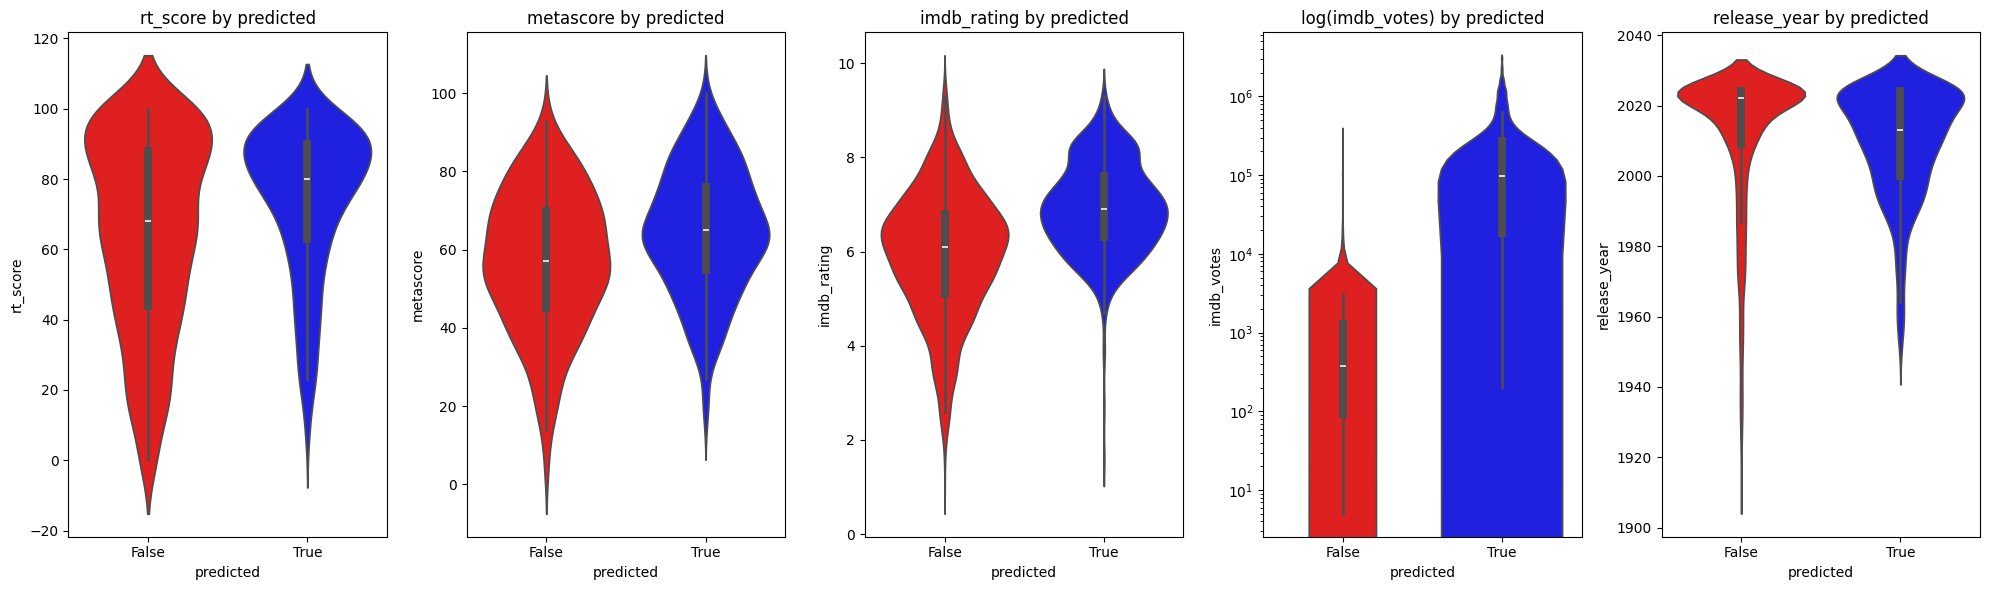

In [5]:
# distribution of numeric values by prediction label
# Create a figure with four subplots side by side
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

# Define the colors for the classes
palette = {False: 'red', True: 'blue'}

# plot
sns.violinplot(x='predicted', y='rt_score', data=pdf, ax=axes[0], hue='predicted', palette=palette)
axes[0].set_title('rt_score by predicted')
axes[0].get_legend().remove()

sns.violinplot(x='predicted', y='metascore', data=pdf, ax=axes[1], hue='predicted', palette=palette)
axes[1].set_title('metascore by predicted')
axes[1].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_rating', data=pdf, ax=axes[2], hue='predicted', palette=palette)
axes[2].set_title('imdb_rating by predicted')
axes[2].get_legend().remove()

sns.violinplot(x='predicted', y='imdb_votes', data=pdf, ax=axes[3], hue='predicted', palette=palette)
axes[3].set_title('log(imdb_votes) by predicted')
axes[3].get_legend().remove()
axes[3].set_yscale('log')

sns.violinplot(x='predicted', y='release_year', data=pdf, ax=axes[4], hue='predicted', palette=palette)
axes[4].set_title('release_year by predicted')
axes[4].get_legend().remove()


# Adjust layout
plt.tight_layout()
plt.show()

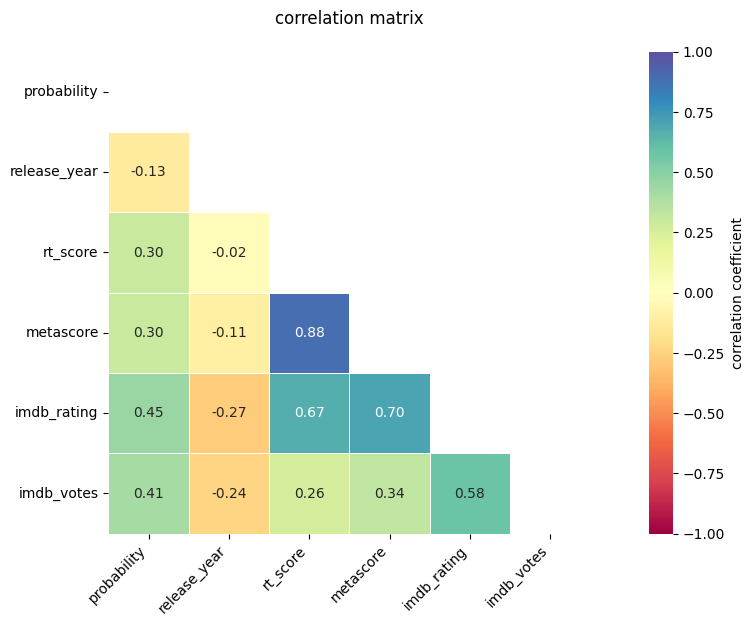

In [6]:
# correlation matrix
corr_df = df.select(
    "probability",
    "release_year",
    "rt_score",
    "metascore",
    "imdb_rating",
    "imdb_votes"
).drop_nulls()

corr_pdf = corr_df.to_pandas()

# Create correlation matrix
corr_matrix = corr_pdf.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Create heatmap
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,  # Show correlation values
    cmap='Spectral',  # Color scheme
    vmin=-1, vmax=1,  # Value range
    center=0,  # Center the colormap at 0
    square=True,  # Make the plot square-shaped
    fmt='.2f',  # Round correlation values to 2 decimal places
    linewidths=0.5,  # Width of the lines between cells
    cbar_kws={'label': 'correlation coefficient'}
)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Add title
plt.title('correlation matrix', pad=20)

# Show the plot
plt.show()

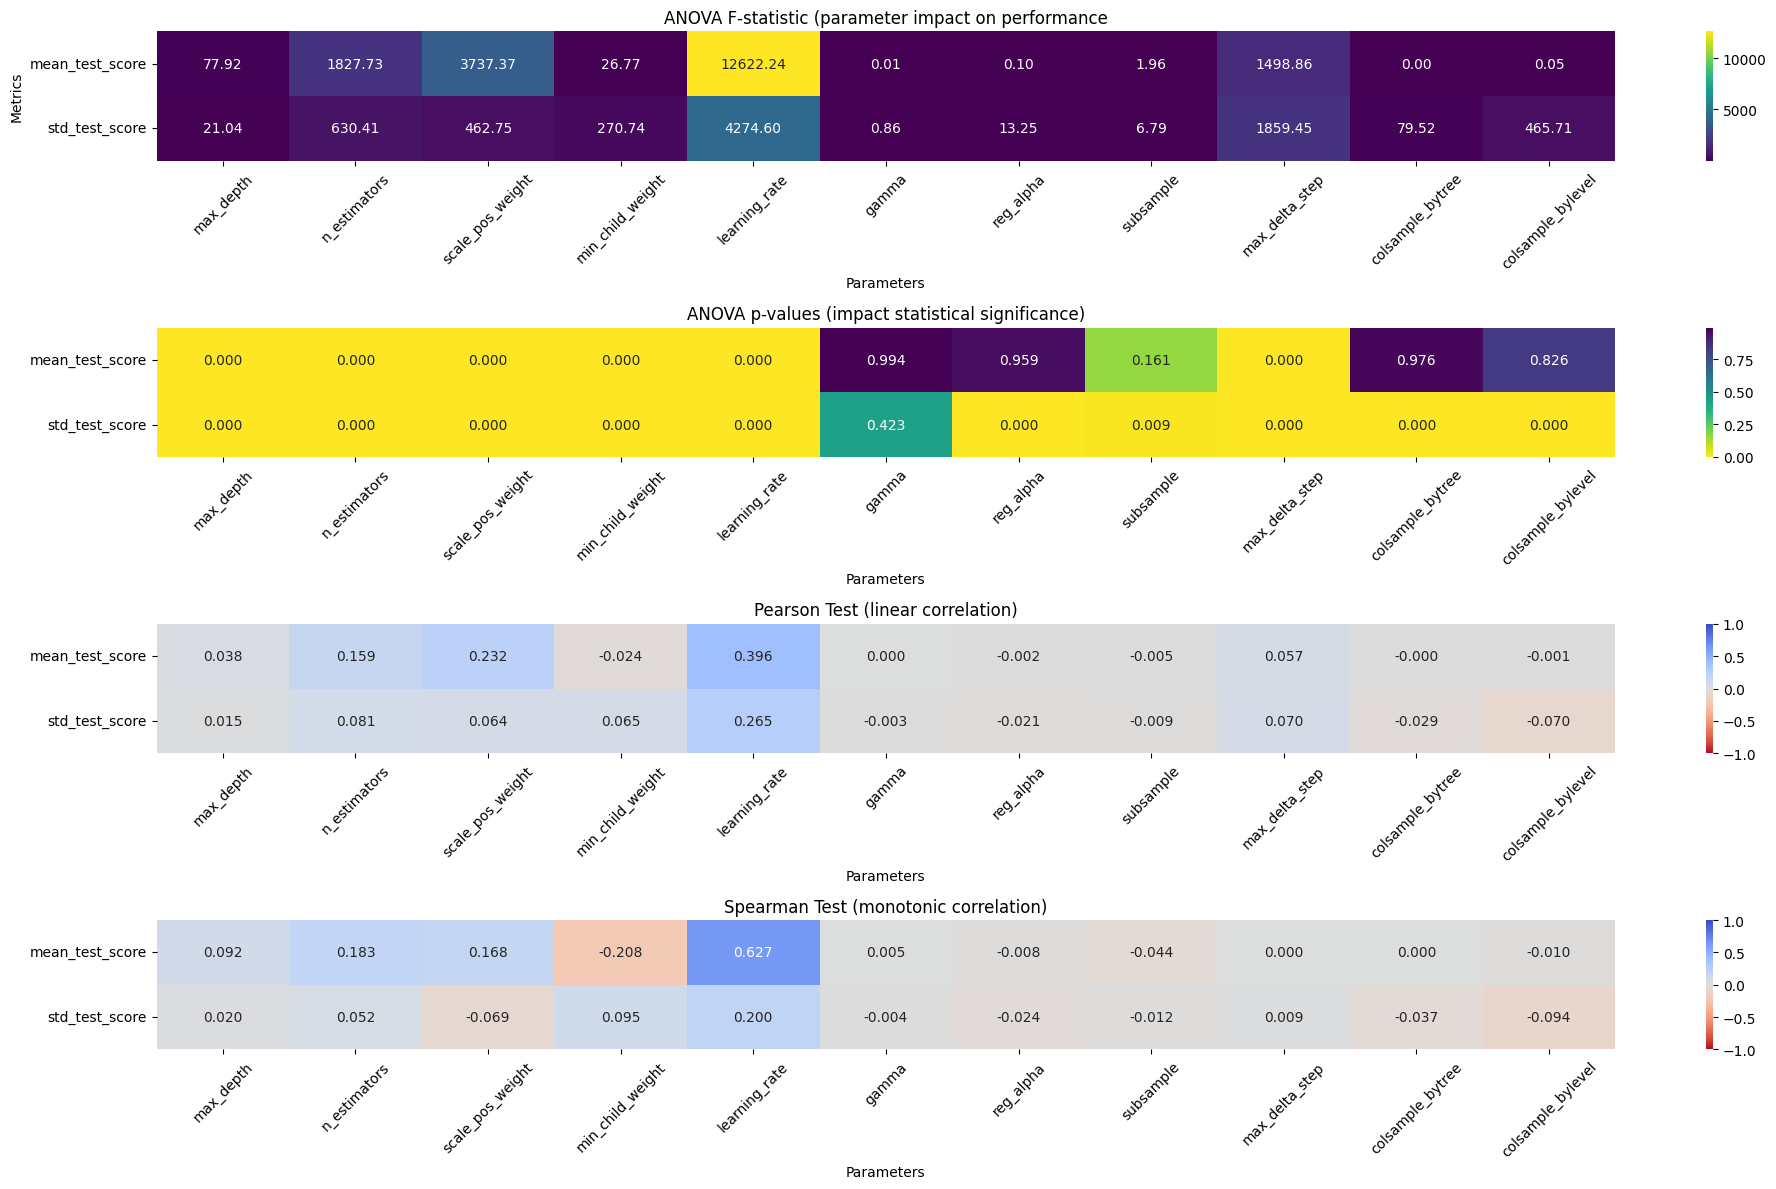

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import f_oneway, pearsonr, spearmanr

# Convert Polars to Pandas
df = gscv_results.to_pandas()

# Define parameter columns (excluding enable_categorical since it's always True)
param_cols = ['param_max_depth', 'param_n_estimators', 'param_scale_pos_weight', 
              'param_min_child_weight', 'param_learning_rate', 'param_gamma', 
              'param_reg_alpha', 'param_subsample', 'param_max_delta_step', 
              'param_colsample_bytree', 'param_colsample_bylevel']

# Filter to only columns that exist in the dataframe
param_cols = [col for col in param_cols if col in df.columns]

# Define metrics
metrics = ['mean_test_score', 'std_test_score']

# Initialize result matrices
anova_f_stats = np.zeros((len(metrics), len(param_cols)))
anova_p_values = np.zeros((len(metrics), len(param_cols)))
pearson_corrs = np.zeros((len(metrics), len(param_cols)))
spearman_corrs = np.zeros((len(metrics), len(param_cols)))

# Calculate statistics for each parameter and metric
for i, metric in enumerate(metrics):
    for j, param in enumerate(param_cols):
        # Convert parameter to categorical for ANOVA
        param_categorical = df[param].astype('category')
        metric_values = df[metric]
        
        # ANOVA test
        groups = [metric_values[param_categorical == cat] for cat in param_categorical.cat.categories]
        # Remove empty groups
        groups = [group for group in groups if len(group) > 0]
        if len(groups) > 1:
            f_stat, p_val = f_oneway(*groups)
            anova_f_stats[i, j] = f_stat
            anova_p_values[i, j] = p_val
        
        # Pearson correlation (treating parameter as numeric)
        try:
            param_numeric = pd.to_numeric(df[param])
            pearson_corr, _ = pearsonr(param_numeric, metric_values)
            pearson_corrs[i, j] = pearson_corr
        except:
            pearson_corrs[i, j] = np.nan
        
        # Spearman correlation
        try:
            param_numeric = pd.to_numeric(df[param])
            spearman_corr, _ = spearmanr(param_numeric, metric_values)
            spearman_corrs[i, j] = spearman_corr
        except:
            spearman_corrs[i, j] = np.nan

# Clean parameter names for display
param_names = [col.replace('param_', '') for col in param_cols]

# Create the figure with 4 subplots in one row
fig, axes = plt.subplots(4, 1, figsize=(20, 12))

# Plot 1: ANOVA F-statistics
sns.heatmap(anova_f_stats, annot=True, fmt='.2f', cmap='viridis', 
            xticklabels=param_names, yticklabels=metrics, ax=axes[0])
axes[0].set_title('ANOVA F-statistic (parameter impact on performance')
axes[0].set_xlabel('Parameters')
axes[0].set_ylabel('Metrics')

# Plot 2: ANOVA p-values
sns.heatmap(anova_p_values, annot=True, fmt='.3f', cmap='viridis_r', 
            xticklabels=param_names, yticklabels=metrics, ax=axes[1])
axes[1].set_title('ANOVA p-values (impact statistical significance)')
axes[1].set_xlabel('Parameters')
axes[1].set_ylabel('')

# Plot 3: Pearson correlations
sns.heatmap(pearson_corrs, annot=True, fmt='.3f', cmap='coolwarm_r', 
            xticklabels=param_names, yticklabels=metrics, ax=axes[2], 
            vmin=-1, vmax=1)
axes[2].set_title('Pearson Test (linear correlation)')
axes[2].set_xlabel('Parameters')
axes[2].set_ylabel('')

# Plot 4: Spearman correlations
sns.heatmap(spearman_corrs, annot=True, fmt='.3f', cmap='coolwarm_r', 
            xticklabels=param_names, yticklabels=metrics, ax=axes[3], 
            vmin=-1, vmax=1)
axes[3].set_title('Spearman Test (monotonic correlation)')
axes[3].set_xlabel('Parameters')
axes[3].set_ylabel('')

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

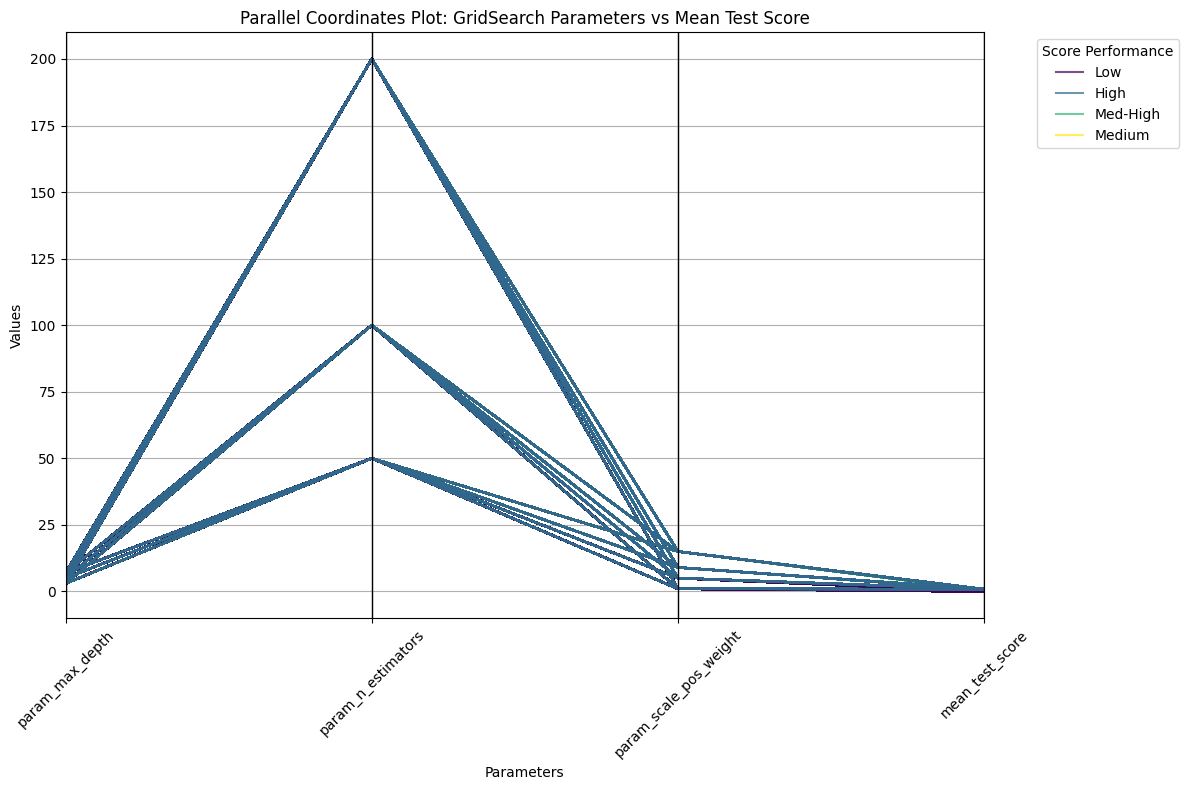

In [8]:
# grid search analysis
from pandas.plotting import parallel_coordinates

# Convert Polars to Pandas
df = gscv_results.to_pandas()

# Select the columns we need for the parallel coordinates plot
plot_data = df[['param_max_depth', 'param_n_estimators', 'param_scale_pos_weight', 'mean_test_score']].copy()

# Create bins for mean_test_score to use as categories for coloring
# This helps visualize which parameter combinations lead to better scores
plot_data['score_bin'] = pd.cut(plot_data['mean_test_score'], 
                               bins=5, 
                               labels=['Low', 'Low-Med', 'Medium', 'Med-High', 'High'])

# Create the parallel coordinates plot
plt.figure(figsize=(12, 8))
parallel_coordinates(plot_data, 
                    'score_bin',
                    cols=['param_max_depth', 'param_n_estimators', 'param_scale_pos_weight', 'mean_test_score'],
                    alpha=0.7,
                    colormap='viridis')

plt.title('Parallel Coordinates Plot: GridSearch Parameters vs Mean Test Score')
plt.xlabel('Parameters')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(title='Score Performance', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

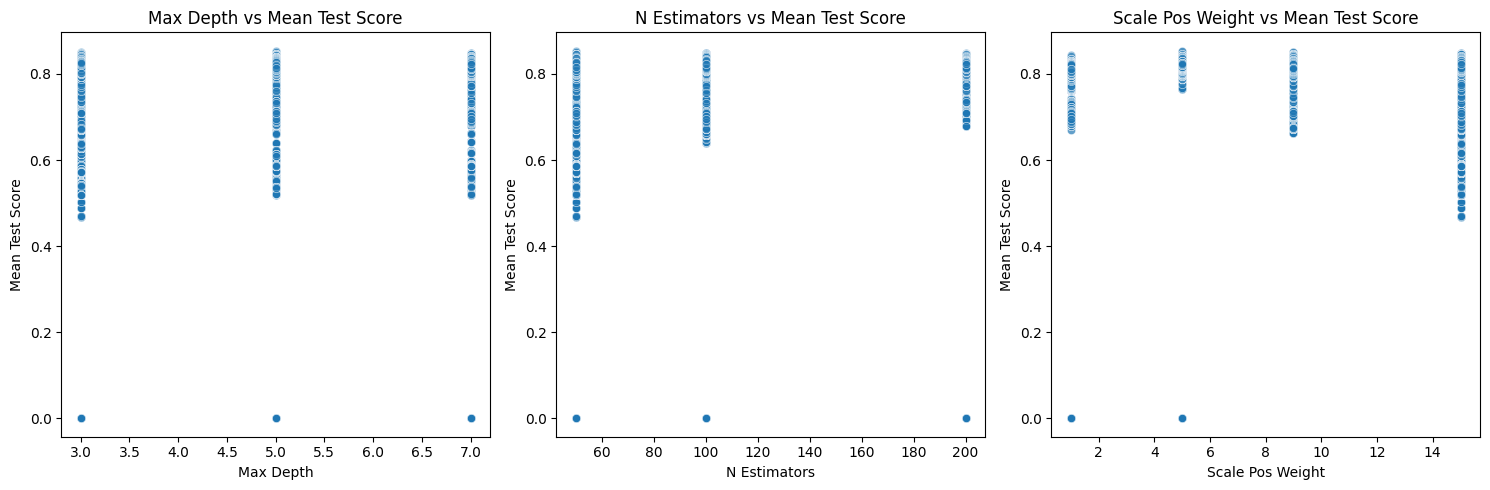

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Polars to Pandas
df = gscv_results.to_pandas()

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatter plot 1: param_max_depth vs mean_test_score
sns.scatterplot(data=df, x='param_max_depth', y='mean_test_score', ax=axes[0], alpha=0.7)
axes[0].set_title('Max Depth vs Mean Test Score')
axes[0].set_xlabel('Max Depth')
axes[0].set_ylabel('Mean Test Score')

# Scatter plot 2: param_n_estimators vs mean_test_score
sns.scatterplot(data=df, x='param_n_estimators', y='mean_test_score', ax=axes[1], alpha=0.7)
axes[1].set_title('N Estimators vs Mean Test Score')
axes[1].set_xlabel('N Estimators')
axes[1].set_ylabel('Mean Test Score')

# Scatter plot 3: param_scale_pos_weight vs mean_test_score
sns.scatterplot(data=df, x='param_scale_pos_weight', y='mean_test_score', ax=axes[2], alpha=0.7)
axes[2].set_title('Scale Pos Weight vs Mean Test Score')
axes[2].set_xlabel('Scale Pos Weight')
axes[2].set_ylabel('Mean Test Score')

plt.tight_layout()
plt.show()

## outlier analysis

In [10]:
# show outliers
# note: the conditional format will not render in github
false_negatives = df.filter(pl.col("cm_value")=="FN").sort("probability").to_pandas()

# Create styled table with conditional formatting
styled_false_negatives = (false_negatives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false positives')
)

display(styled_false_negatives)

false_positives = df.filter(pl.col("cm_value")=="FP").sort("probability", descending=True).to_pandas()

# Create styled table with conditional formatting
styled_false_positives = (false_positives
    .style
    .background_gradient(subset=['probability'], cmap='RdYlGn_r')  # Red to Yellow to Green (reversed)
    .bar(subset=['probability'], color='#4a90e2', align='mid')  # Add bar charts
    .format({'probability': '{:,.0f}', 'probability': '{:.2f}%'})  # Format numbers
    .set_caption('false negatives')
)

display(styled_false_positives)

TypeError: Index(...) must be called with a collection of some kind, <Expr ['[(col("cm_value")) == ("FN")]'] at 0x15FA4EDA450> was passed

In [ ]:
# export false positives and false negaties for further investigation
false_positives = df.filter(pl.col('cm_value')=="FP").sort("probability")

with open("../data/false_positives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_positives.iter_rows(named=True)]
    json.dump(records, file, indent=4)

false_negatives = df.filter(pl.col('cm_value')=="FN").sort("probability", descending=True)

with open("../data/false_negatives.json", "w") as file:
    # Convert to records (list of dicts, each representing a row)
    records = [row for row in false_negatives.iter_rows(named=True)]
    json.dump(records, file, indent=4)


### issues discoverd with training data

- parsing issue for some titles leading to issues with metadata collection
    - investigate parsing issues
- some items seems to have properly parsed values for media_title, but still have not succesfully collected metadata
    - re-run through OMDB API
